#Code

In [9]:
%matplotlib inline

In [10]:
import os
import numpy as np
import scipy
import scipy.special
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt


class Point(object):

    def __init__(self, *coords, **kwds):
        self.coords = [float(coord) for coord in coords]
        self.w = float(kwds.setdefault('w', 1.0))

    def __getitem__(self, key):
        return self.coords[key]

    def __setitem__(self, key, value):
        self.coords[key] = value

    def __call__(self):
        return np.array(self.coords)

    @property
    def dim(self):
        return len(self.coords)

    def dist(self, other):
        return scipy.linalg.norm(self() - other())


class Bezier(object):

    def __init__(self, ctrl_points=None):
        if len(ctrl_points) < 1:
            raise ValueError('Bezier must have at least 2 control points')
        else:
            self.ctrl_points = [Point(*cp) for cp in ctrl_points]

    @property
    def deg(self):
        return len(self.ctrl_points) - 1

    def point(self, t):
        new_coords = np.zeros_like(self.ctrl_points[0]())

        d = 0.0
        for i, cp in enumerate(self.ctrl_points):
            b = scipy.special.binom(self.deg, i) * (1-t)**(self.deg-i) * t**(i)
            for i, coord in enumerate(new_coords):
                new_coords[i] += cp.w*b*cp[i]
            d += cp.w*b
        new_coords /= d

        return Point(*new_coords)

    def nearest_point(self, point, t_guess=0.0, tol=0.00001):
        def error_fn(t_trial, point):
            return point.dist(self.point(t_trial[0]))

        t_nearest = scipy.optimize.fmin(error_fn, t_guess, args=(point,), disp=0, ftol=0.0001)

        return self.point(t_nearest[0])

    def error(self, pnts):

        rpoints = [Point(*pnt) for pnt in pnts]

        e = 0.0
        for i, rpoint in enumerate(rpoints):
            p = float(i) / float(len(rpoints))
            e += rpoint.dist(self.nearest_point(rpoint, t_guess=p))
        return e


def fit_bezier(pnts, deg):
    if deg < 1:
        raise ValueError('Bezier degree must be greater than 1')

    def solve_for_cs(ts, ds, deg):
        """Takes an input series of values (ds) and uses them to solve Ax = b
        ts = time steps between ds
        ds = values

        """

        # Create A
        # am, bm = [1, 4, 6, 4, 1] (binomial array for deg 4)
        am = np.array([[scipy.special.binom(deg, i) for i in range(deg + 1)]])
        bm = np.array([[scipy.special.binom(deg, i) for i in range(deg + 1)]]).T

        # cm = matrix of 1's and -1's (based on index, e.g. for even deg: 0,0 = 1; 0,1 = -1;, 0,2 = 1, etc)
        cm = (1 - 2 * np.mod(np.sum(np.indices((deg+1, deg+1)), axis=0), 2 * np.ones((deg+1, deg+1))))

        # Fix for odd deg (the array needs to be flipped... -1, 1 instead of 1, -1)
        if deg % 2:
            cm *= -1

        # A is square binomial matrix scaled by matrix of 1's and -1s (scalar of two from differentiation)
        A = 2 * am * bm * cm

        # Create B
        # B is matrix of exponents for (t-1) [[8, 7, 6, 5, 4], [7, 6, 5, 4, 3], ...[4, 3, 2, 1, 0]]
        B = np.zeros((deg + 1, deg + 1))
        B[-1] = np.arange(deg, -1, -1)

        for i in range(deg - 1, -1, -1):
            B[i] = B[i+1] + 1

        # Create C
        # C is matrix of exponents for t [[0, 1, 2, 3, 4], [1, 2, 3, 4, 5], ...[4, 5, 6, 7, 8]]
        C = np.zeros((deg + 1, deg + 1))
        C[0] = np.arange(deg + 1)

        for i in range(deg):
            C[i+1] = C[i] + 1

        # Create D
        # am is 1 row matrix of binomial coefficients
        am = np.array([scipy.special.binom(deg, i) for i in range(deg + 1)])

        # bm is matrix of 1's and -1's (based on index)
        bm = (-1 + 2 * np.mod(np.sum(np.indices((1, deg+1)), axis=0).flatten(), 2 * np.ones((deg+1))))

        # D is binomial coefficients scaled by matrix of 1's and -1's (scalar of two from differentiation)
        D = 2 * am * bm

        # Create E
        E = np.arange(deg, -1, -1)

        # Create F
        F = np.arange(deg + 1)

        # Function to create A matrix in Ax=b (using each input from above (A, B, C))
        def A_fn(ts, A_i, B_i, C_i):
            return sum([A_i * (t - 1) ** B_i * t ** C_i for t in ts])

        def b_fn(ts, ds, D_i, E_i, F_i):
            return -1.0 * sum([D_i * (t - 1) ** E_i * d * t ** F_i for t, d in zip(ts, ds)])

        # Matrix A
        A = np.array([A_fn(ts, A_i, B_i, C_i) for A_i, B_i, C_i in zip(A.flatten(), B.flatten(), C.flatten())]).reshape((deg+1, deg+1))

        # Vector b
        b = np.array([b_fn(ts, ds, D_i, E_i, F_i) for D_i, E_i, F_i in zip(D.flatten(), E.flatten(), F.flatten())]).reshape((deg+1, 1))

        # Solve Ax = b
        return scipy.linalg.solve(A, b)

    # Set up time steps (normalized 3D cummulative distances)
    dists = np.cumsum([np.linalg.norm(p) for p in np.diff([np.array(p) for p in pnts], axis=0)])
    ts = [0] + [dist / max(dists) for dist in dists]

    # Fit spline through each direction independently
    ctrl_xs = solve_for_cs(ts, [pnt[0] for pnt in pnts], deg)
    ctrl_ys = solve_for_cs(ts, [pnt[1] for pnt in pnts], deg)
    ctrl_zs = solve_for_cs(ts, [pnt[2] for pnt in pnts], deg)

    ctrl_pnts = [(x, y, z) for x, y, z in zip(ctrl_xs, ctrl_ys, ctrl_zs)]
    return Bezier(ctrl_pnts)


#Inputs

In [11]:

# pnts = np.loadtxt('pnts.csv', delimiter=",")

pnts = np.array([(-0.83896, 0.45460, 8.17325),(-0.85060, 0.46279, 8.16633),(-0.83474, 0.44247, 8.18516),
                 (-0.79123, 0.41704, 8.17927),(-0.77126, 0.41433, 8.19266),(-0.77882, 0.41332, 8.19295),
                 (-0.76087, 0.39112, 8.16877),(-0.73086, 0.37136, 8.20034),(-0.70436, 0.33900, 8.18335),
                 (-0.70038, 0.34861, 8.18074),(-0.67073, 0.33879, 8.20578),(-0.65981, 0.31676, 8.17875),
                 (-0.66563, 0.29528, 8.17924),(-0.63595, 0.30427, 8.18212),(-0.61217, 0.26826, 8.21973),
                 (-0.61148, 0.26199, 8.18864),(-0.57946, 0.24566, 8.21538),(-0.55271, 0.24412, 8.22252),
                 (-0.52325, 0.25088, 8.19399),(-0.50147, 0.23612, 8.23423),(-0.49305, 0.20233, 8.23709),
                 (-0.49879, 0.20632, 8.20836),(-0.46871, 0.20285, 8.20572),(-0.46451, 0.19908, 8.21169),
                 (-0.41340, 0.16636, 8.22179),(-0.41198, 0.16391, 8.24898),(-0.40901, 0.15455, 8.21518),
                 (-0.37370, 0.13627, 8.22396),(-0.35991, 0.15885, 8.23839),(-0.33365, 0.14795, 8.25083),
                 (-0.33003, 0.11533, 8.23844),(-0.29998, 0.11115, 8.24191),(-0.25635, 0.11612, 8.26294),
                 (-0.24299, 0.10197, 8.25460),(-0.24427, 0.09429, 8.24977),(-0.23048, 0.08763, 8.25289),
                 (-0.20458, 0.07398, 8.23515),(-0.18381, 0.07466, 8.24175),(-0.16649, 0.06427, 8.24268),
                 (-0.12102, 0.05247, 8.26875),(-0.10571, 0.05606, 8.24740),(-0.10995, 0.04129, 8.25527),
                 (-0.07231, 0.01778, 8.26590),(-0.05079, 0.01114, 8.26215),(-0.02465, 0.03365, 8.27811),
                 (-0.00174, -0.01179, 8.29120),(0.01071, -0.00595, 8.26810),(0.02214, 0.02537, 8.29547),
                 (0.03685, 0.00316, 8.27698),(0.06296, 0.02415, 8.30084),(0.08736, 0.02996, 8.29351),
                 (0.09955, 0.04165, 8.28308),(0.12697, 0.04732, 8.30411),(0.13995, 0.06454, 8.28891),
                 (0.17488, 0.06558, 8.30616),(0.16333, 0.06295, 8.27786),(0.17954, 0.05176, 8.29236),
                 (0.20072, 0.07589, 8.31322),(0.25289, 0.06880, 8.29806),(0.26480, 0.09542, 8.32484),
                 (0.26155, 0.08033, 8.29463),(0.32007, 0.10652, 8.29364),(0.31574, 0.09993, 8.30895),
                 (0.35261, 0.11543, 8.31904),(0.35394, 0.11429, 8.31510),(0.38196, 0.09598, 8.33471),
                 (0.39309, 0.10235, 8.31339),(0.42256, 0.10923, 8.32950),(0.45646, 0.14525, 8.34217),
                 (0.45608, 0.14490, 8.34412),(0.47028, 0.12680, 8.31637),(0.49886, 0.15558, 8.34759),
                 (0.51085, 0.15941, 8.32322),(0.54115, 0.15274, 8.32372),(0.57290, 0.15054, 8.33298),
                 (0.57960, 0.15814, 8.34543),(0.61920, 0.16494, 8.33677),(0.63349, 0.17448, 8.36058),
                 (0.64400, 0.19277, 8.35656),(0.66288, 0.16319, 8.36277),(0.69230, 0.18089, 8.36094),
                 (0.70256, 0.18774, 8.35969),(0.73840, 0.20645, 8.35684),(0.77300, 0.18981, 8.34291),
                 (0.77261, 0.20431, 8.34717),(0.79470, 0.21357, 8.35946),(0.84364, 0.22156, 8.34852),
                 (0.84519, 0.21800, 8.36873),(0.84785, 0.19822, 8.37173),(0.86988, 0.21286, 8.37100)])

#Results

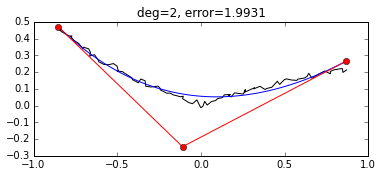

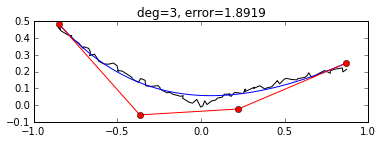

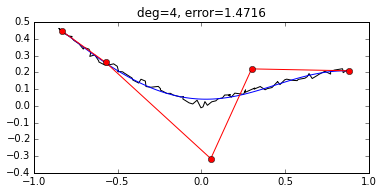

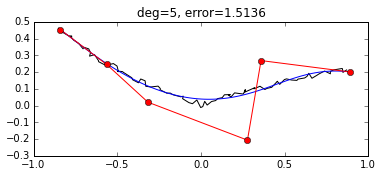

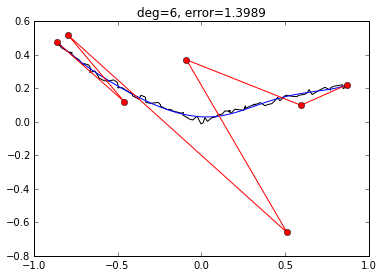

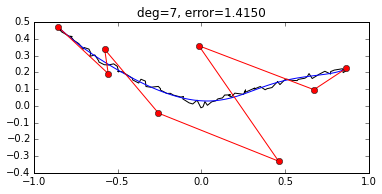

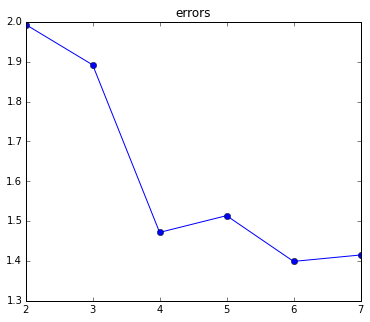

In [12]:
errors = []

fig_size = plt.rcParams["figure.figsize"]
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

for i in range(2,8):
    bez = fit_bezier(pnts, i)
    err = bez.error(pnts)
    errors.append(err)

    bpnts = [bez.point(i) for i in scipy.linspace(0.0, 1.0, 100)]
    plt.axes().set_aspect('equal')
    plt.title('deg={0}, error={1:.4f}'.format(i, err))
    plt.plot([p[0] for p in pnts], [p[1] for p in pnts], 'k-')
    plt.plot([bp[0] for bp in bpnts], [bp[1] for bp in bpnts], 'b-')
    plt.plot([cp[0] for cp in bez.ctrl_points], [bp[1] for bp in bez.ctrl_points], 'r-o')
    plt.show()

fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('errors')
plt.plot(range(2,8), errors, 'b-o')
plt.show()